Notebook to convert animation video to format expected by SSD1306 display
* extract pixels
* skip duplicate frames
* (optional) upscale 2x
* pack into bytes (SSD1306 expects 1x8 column of pixel in each byte)
* create .c & .h files

**All credit to John Bond (u/Kaimatten) for the amazing animation**

original at https://www.reddit.com/r/PixelArt/comments/hoxd95/1_minute_of_1_bit_cat_animations


In [1]:
import os
from typing import Any
from glob import glob
from collections import Counter

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

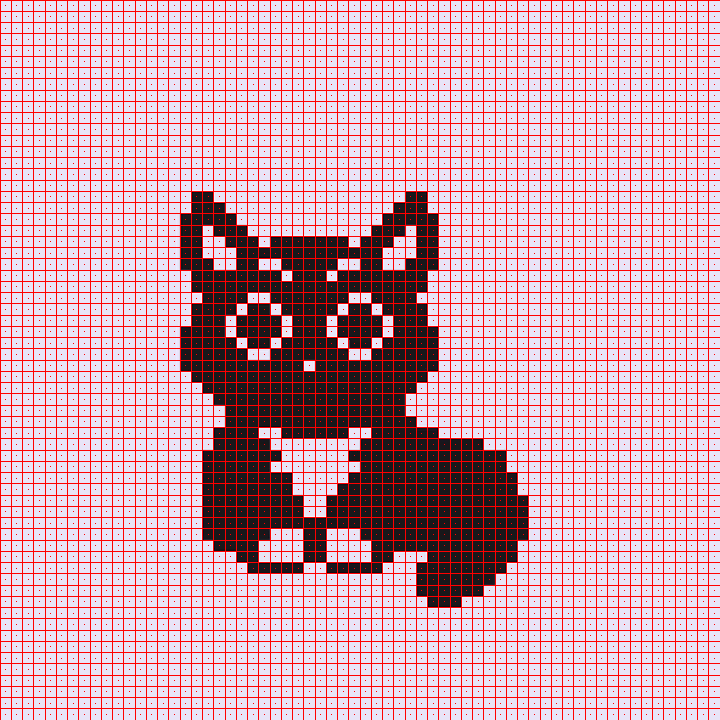

[67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 700, 703, 704, 705, 707, 708, 710, 713]


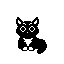

In [3]:
i = Image.open("frames/cat00001.png")
real_size = []
p = i.load()

assert i.width == i.height

n = 64
w = i.width
d = w / n

for row in range(n):
    for col in range(w):
        p[row * d, col] = (255, 0, 0)

for col in range(n):
    for row in range(w):
        p[row, col * d] = (255, 0, 0)

for row in range(n):
    out_row = []
    for col in range(n):
        out_row.append(p[row * d + d / 2, col * d + d / 2])
        p[row * d + d / 2, col * d + d / 2] = (255, 0, 0)
    real_size.append(out_row)
real_size = np.array(real_size)
one_bit = (real_size.sum(axis=2) > 500).T

display(i)
print(sorted(set(int(x) for x in real_size.sum(axis=2).reshape(-1))))
display(Image.fromarray(one_bit))

In [4]:
def convert_to_1_bit(p: str) -> np.ndarray:
    i = Image.open(p)
    p = i.load()
    
    real_size = []
    for row in range(n):
        out_row = []
        for col in range(n):
            out_row.append(p[row * d + d / 2, col * d + d / 2])
            p[row * d + d / 2, col * d + d / 2] = (255, 0, 0)
        real_size.append(out_row)
    real_size = np.array(real_size)
    one_bit = (real_size.sum(axis=2) > 500).T
    return one_bit

In [5]:
frames = []
frame_counts = []
paths = glob("frames/*.png")
print(f"{len(paths)} video frames")
count = 1
for p in sorted(glob("frames/*.png")):
    one_bit = convert_to_1_bit(p)
    if frames and (frames[-1] == one_bit).all():
        count += 1
        continue
    frames.append(one_bit)
    frame_counts.append(count)
    count = 1
print(f"{len(frames)} distinct frames after processing")

1797 video frames
348 distinct frames after processing


In [6]:
Counter(frame_counts)

Counter({3: 268,
         6: 25,
         9: 17,
         12: 16,
         24: 10,
         18: 5,
         15: 2,
         1: 1,
         30: 1,
         27: 1,
         21: 1,
         45: 1})

In [7]:
frame_counts = [max(1, x // 3) for x in frame_counts]

In [8]:
upscaled_frames = [f.repeat(2, axis=0).repeat(2, axis=1)[35:-29,:] for f in frames]

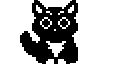

In [9]:
Image.fromarray(upscaled_frames[141])

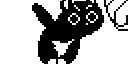

In [10]:
Image.fromarray(upscaled_frames[59])

In [11]:
def pack_frame_1to1(frame: np.ndarray, invert: bool=False) -> list[list[int]]:
    packed_frame = []
    fill = 0 if invert else 255
    padding = ((128 - frame.shape[1])//2)
    assert 2 * padding + frame.shape[1] == 128
    for row0 in range(n//8):
        out_row = [fill] * padding
        for col in range(frame.shape[1]):
            # take vertical strips of 8 pixels to form each byte
            bits = frame[row0 * 8:row0*8 + 8,col]
            out_row.append(int("".join("1" if x else "0" for x in reversed(bits)), base=2))
        out_row += [fill] * padding
        packed_frame.append(out_row)
    return packed_frame

In [33]:
def create_frame_file(
    out_folder: str,
    frames: list[np.ndarray],
    frame_counts: list[int],
    invert: bool,
    out_name: str,
    loop: bool = False,
    init_idx: int | None = None,
    extra_anims: list[dict[str, Any]] = None,
) -> None:
    out_str = "// original animation by u/Kaimatten\n"
    out_str += "// https://www.reddit.com/r/PixelArt/comments/hoxd95/1_minute_of_1_bit_cat_animations\n\n"
    out_str += f'#include "anim_{out_name}.h"\n\n'

    out_str += f"const uint8_t {out_name}_frames[{len(frames)}][8][128] = {{\n"
    
    for frame in frames:
        out_str += "{\n"
        out_str += ",\n".join("{" + ",".join(str(x) for x in row) + "}"  for row in pack_frame_1to1(frame))
        out_str += "\n},"
    out_str += "};\n"
    out_str += f"const uint8_t {out_name}_frame_counts[{out_name.upper()}_N_FRAMES] = {{{','.join(str(x) for x in frame_counts)}}};\n"
    out_str += f"""
struct animation anim_{out_name} = {{
    .frames = {out_name}_frames,
    .frame_counts = {out_name}_frame_counts,
    .frame_step = 1,
    .start_idx = 0,
    .end_idx = {len(frames) - 1},
    .init_idx = {0 if init_idx is None else init_idx},
    .loop = {'true' if loop else 'false'},
}};
"""

    extra_anims_h = ""
    for e in extra_anims or []:
        assert e.keys() >= {"name", "start_idx", "end_idx", "init_idx", "frame_step", "loop"}
        out_str += f"""
struct animation anim_{e['name']} = {{
    .frames = {out_name}_frames,
    .frame_counts = {out_name}_frame_counts,
    .start_idx = {e['start_idx']},
    .end_idx = {e['end_idx']},
    .init_idx = {e['init_idx']},
    .frame_step = {e['frame_step']},
    .loop = {'true' if e['loop'] else 'false'},
}};
"""
        extra_anims_h += f"extern struct animation anim_{e['name']};"
    
    with open(os.path.join(out_folder, f"anim_{out_name}.c"), "w") as f:
        f.write(out_str)
    with open(os.path.join(out_folder, f"anim_{out_name}.h"), "w") as f:
        f.write(f"""
#ifndef {out_name.upper()}_H
#define {out_name.upper()}_H
#include "anim.h"
{extra_anims_h}
#define {out_name.upper()}_N_FRAMES {len(frames)}
extern struct animation anim_{out_name};

#endif // {out_name.upper()}_H
"""
               )

In [34]:
create_frame_file(
    "../kbd_firmware/src/animations", 
    upscaled_frames[115:141], 
    frame_counts[115:141], 
    invert=False, 
    out_name="wake",
)

In [35]:
create_frame_file(
    "../kbd_firmware/src/animations", 
    upscaled_frames[100:115], 
    frame_counts[100:115], 
    invert=False, 
    out_name="sleep",
)

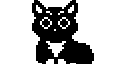

In [36]:
Image.fromarray(upscaled_frames[100])

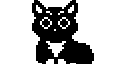

In [37]:
Image.fromarray(upscaled_frames[37])

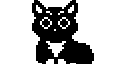

In [38]:
Image.fromarray(upscaled_frames[0])

In [39]:
create_frame_file(
    "../kbd_firmware/src/animations", 
    upscaled_frames[0:38], 
    frame_counts[0:38], 
    invert=False, 
    out_name="idle",
    loop=True,
    init_idx=7,
)